# Hoja de Trabajo 7 - Modelos de Regresión Logística
### Universidad del Valle de Guatemala
#### Minería de Datos

**Diego Garcia Valle** - 22404

**Pablo Cesar Lopez Medina** - 22535

In [38]:
# %pip install -r requirements.txt

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score


In [40]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Punto 1 - Variables Dicotómicas

In [41]:
bins = [0, 130000, 200000, float('inf')]
labels = ['Barata', 'Media', 'Cara']
train_df['PrecioCategoria'] = pd.cut(train_df['SalePrice'], bins=bins, labels=labels)


In [42]:
# Crear variable categórica de precio
bins = [0, 130000, 200000, float('inf')]
labels = ['Barata', 'Media', 'Cara']
train_df['PrecioCategoria'] = pd.cut(train_df['SalePrice'], bins=bins, labels=labels)

# Crear variables dicotómicas
train_df['Es_Barata'] = (train_df['PrecioCategoria'] == 'Barata').astype(int)
train_df['Es_Media'] = (train_df['PrecioCategoria'] == 'Media').astype(int)
train_df['Es_Cara'] = (train_df['PrecioCategoria'] == 'Cara').astype(int)

# Verificar resultado
train_df[['SalePrice', 'PrecioCategoria', 'Es_Barata', 'Es_Media', 'Es_Cara']].head(10)


,SalePrice,PrecioCategoria,Es_Barata,Es_Media,Es_Cara
0,208500,Cara,0,0,1
1,181500,Media,0,1,0
2,223500,Cara,0,0,1
3,140000,Media,0,1,0
4,250000,Cara,0,0,1
5,143000,Media,0,1,0
6,307000,Cara,0,0,1
7,200000,Media,0,1,0
8,129900,Barata,1,0,0
9,118000,Barata,1,0,0


## Punto 2 – División del conjunto de datos

In [43]:
# Eliminar columnas no útiles o objetivo
excluded_columns = [
    'Id', 'SalePrice', 'PrecioCategoria', 'Es_Barata', 'Es_Media', 'Es_Cara'
]

# Seleccionar solo variables numéricas como features
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
features = [col for col in numeric_cols if col not in excluded_columns]

# Variables finales para modelado
X = train_df[features]
y = train_df['Es_Cara']


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (1095, 36), Test: (365, 36)


## Punto 3 – Modelo de regresión logística

In [45]:

# Pipeline: imputación + estandarización + modelo
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

# Validación cruzada con el pipeline completo
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy en cada fold de validación cruzada:", cv_scores)
print("Accuracy promedio:", cv_scores.mean())


Accuracy en cada fold de validación cruzada: [0.92237443 0.9086758  0.92694064 0.89954338 0.92237443]
Accuracy promedio: 0.9159817351598173


### Validación cruzada con pipeline

Hasta este punto, nos dimos cuenta que el modelo de regresión logística no podía entrenarse directamente con los datos porque había valores NaN y también nos dio una advertencia de que no estaba convergiendo (es decir, no llegaba a una solución óptima dentro de las iteraciones permitidas).

Por eso, decidimos hacer un pipeline que básicamente hace tres cosas:
1. **Imputa** (rellena) los valores faltantes con la media de cada columna.
2. **Estandariza** los datos para que todas las variables estén en la misma escala. Esto ayuda a que el modelo entienda mejor los datos y converja más rápido.
3. **Entrena** un modelo de regresión logística con esas transformaciones aplicadas.

Después, usamos validación cruzada con 5 folds para ver qué tan bien se comporta el modelo en diferentes particiones de los datos.

Al interpretar los resultados podemos ver que el modelo logra predecir correctamente si una casa es cara o no con una precisión de aproximadamente **91.6%**, lo cual está bastante bien. Además, los resultados entre folds no varían demasiado, así que el modelo parece estable y no depende de una partición específica.


In [47]:
# Entrenar el pipeline completo sobre TODO el conjunto de entrenamiento
pipeline.fit(X_train, y_train)

# Extraer el modelo entrenado desde el pipeline
modelo_entrenado = pipeline.named_steps['logreg']

# Obtener los coeficientes
coeficientes = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": modelo_entrenado.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

# Mostrar los 10 más influyentes
coeficientes.head(10)


,Variable,Coeficiente
3,OverallQual,1.614721
5,YearBuilt,1.085585
15,GrLivArea,0.895538
13,2ndFlrSF,0.834349
6,YearRemodAdd,0.624175
11,TotalBsmtSF,0.514237
2,LotArea,0.441470
25,GarageCars,0.404756
8,BsmtFinSF1,0.395582
4,OverallCond,0.394632


### Análisis de los coeficientes del modelo

Después de entrenar el modelo, revisamos los coeficientes para entender cuáles variables tienen más impacto en predecir si una casa es cara o no.

Los coeficientes más altos indican que al aumentar esa variable, también aumenta la probabilidad de que la casa sea cara.

#### Top 3 variables más influyentes:
1. **OverallQual** – Calidad general de la construcción: tiene el coeficiente más alto, lo cual tiene sentido porque mientras mejor es la calidad, más cara tiende a ser la casa.
2. **YearBuilt** – Año de construcción: las casas más nuevas suelen valer más.
3. **GrLivArea** – Área habitable sobre el suelo: más espacio = más valor.

Otras variables que también influyen bastante son 2ndFlrSF (segunda planta), GarageCars (espacio para autos) y TotalBsmtSF (sótano total), que también reflejan mayor comodidad o tamaño de la casa.

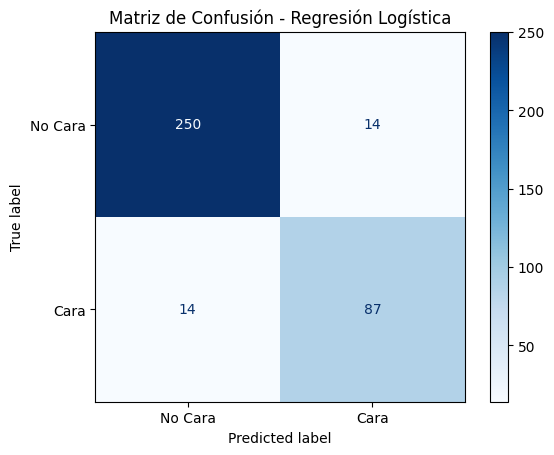

              precision    recall  f1-score   support

     No Cara       0.95      0.95      0.95       264
        Cara       0.86      0.86      0.86       101

    accuracy                           0.92       365
   macro avg       0.90      0.90      0.90       365
weighted avg       0.92      0.92      0.92       365



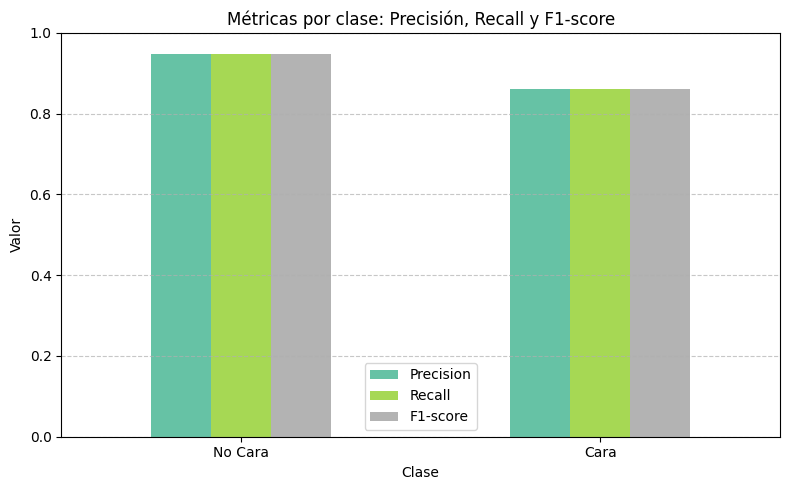

In [ ]:

# Hacer predicciones con el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Cara", "Cara"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

# Reporte de clasificación
print(classification_report(y_test, y_pred, target_names=["No Cara", "Cara"]))


# Calcular métricas por clase manualmente
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

labels = ["No Cara", "Cara"]

# Crear un DataFrame para graficar
metricas_df = pd.DataFrame({
    "Clase": labels,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
})

metricas_df.set_index("Clase").plot(kind="bar", figsize=(8, 5), ylim=(0, 1), colormap="Set2")
plt.title("Métricas por clase: Precisión, Recall y F1-score")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



### Análisis de Resultados

La matriz de confusión muestra que el modelo está funcionando bastante bien para predecir si una casa es cara o no cara.

- 250 verdaderos negativos (No Cara correctamente clasificados)
- 87 verdaderos positivos (Cara correctamente clasificados)
- 14 falsos positivos (predijo "Cara" pero era "No Cara")
- 14 falsos negativos (predijo "No Cara" pero era "Cara")

- **Accuracy total**: **92%** → Muy bueno. El modelo acierta 9 de cada 10 veces.
- **Precisión para casas caras**: **0.86**
- **Recall para casas caras**: **0.86**
- **F1-score para casas caras**: **0.86**


En el gráfico de barras se visualiza claramente cómo se comporta el modelo para cada clase (`No Cara` y `Cara`) en términos de:

- **Precisión** (qué tan confiables son sus predicciones)
- **Recall** (qué tanto logra encontrar los ejemplos correctos)
- **F1-score** (balance entre precisión y recall)

Para la clase No Cara, el modelo tiene métricas casi perfectas (~0.95). Para la clase Cara, todas las métricas están en torno a 0.86, lo cual sigue siendo muy sólido. La diferencia entre clases es normal, ya que hay más ejemplos de casas "No Cara" en los datos (desbalance leve).

Este gráfico ayuda a visualizar mejor que, aunque el modelo funciona muy bien en general, es un poquito mejor clasificando las casas que no son caras — lo cual es entendible, ya que hay más datos de ese tipo en el conjunto de entrenamiento.


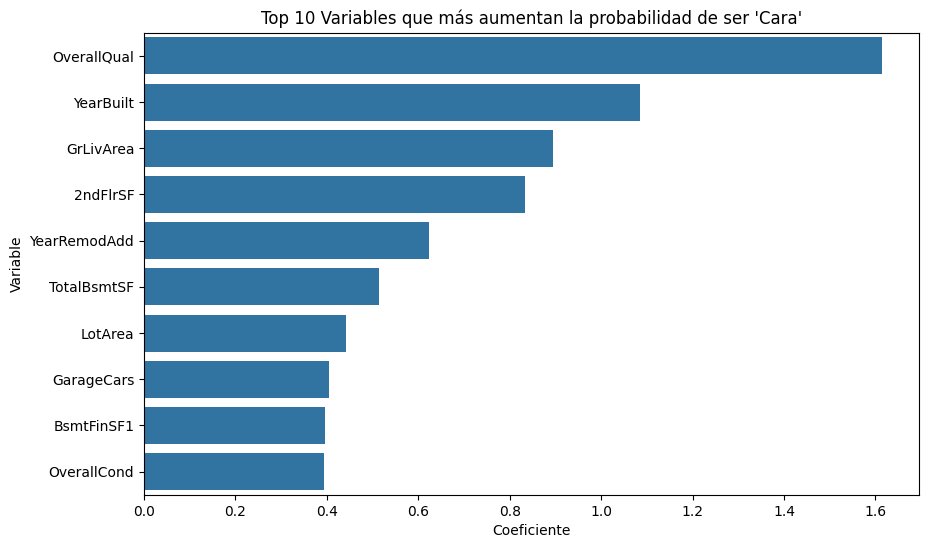

In [48]:
# Visualizar los coeficientes más relevantes
plt.figure(figsize=(10, 6))
sns.barplot(x="Coeficiente", y="Variable", data=coeficientes.head(10))
plt.title("Top 10 Variables que más aumentan la probabilidad de ser 'Cara'")
plt.show()
